```
Yizhou 2020-9-4:
This code is investigating the SNR of EigenFace data by PCA, BS, RS, etc.
```

In [1]:
import os;
from google.colab import drive
#drive.mount('/content/drive', force_remount=True);
drive.mount('/content/drive', force_remount=True);
path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/Eigen Face";
os.chdir(path);
os.listdir(path);

Mounted at /content/drive


In [2]:
import time;

In [3]:
Section_1 = 1;
Section_2 = 0;
Section_3 = 0;
Section_4 = 1; ## recons + pca + contours
Section_5 = 1; ## Anscombe tranform + software pca

## 1. Principal component analysis
Suppose ```X_train``` is the training set (400 by 4096, each row reshapes a image from a 64 by 64 image).  
By calculate the covariance matrix, we can diagonize it by SVD and get the tansform matrix standing for rotating the data dimension into orthogonal directions.  
The algorithms is 
1. Calculate the mean of $X_{train}$: ```X_train_mean = np.mean(X_train, axis = 0)```
2. Move the ```X_train``` to the origin: ```X_train_center = X_train - X_train_mean```  
3. Calculate the covariance matrix $S$: ```S = X_train_center.T.dot(X_train_center)```  
4. Get the eigen vectors: ```eigen_val, eigen_vec = np.linalg.eig(S)```
5. Keep the greatest few components: ```eigen_vec[:n_components,:]```  
---
This can be done quickly by Sci-kit learn package.

In [4]:
## using packages
'''
import os;
path = os.getcwd(); ## get current path
path += '\..';
os.chdir(path);
print(os.getcwd())
'''

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

#plt.style.use("seaborn-ticks")

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

from scipy.fftpack import dct, idct;    

In [5]:
class Research_object(object): ## This class is used to save all the important data and make the structure clear
    def __init__(self):
        self.P = {};

    def add_item(self, name, item):
        if name not in self.P:
            self.P[name] = item;
        else:
            choice = input("Item name already exists. Force to replace?\n1.Yes \t 2.No\n");
            if choice == 1:
                self.P[name] = item;
    
    def rm_item(self, name):
        if name in self.P:
            del self.P[name];
        else:
            print("Item name doesn't exist.");
            
class Masks(object):
    def __init__(self):
        pass;
    ############################################################################    
    ## Unity matrix
    def Unity_matrix(self, N):
        return np.eye(N);       
    
    ############################################################################ 
    ## DCT_SECTION
    def dct2(self,block,padding = False):        
        if not np.all(padding):            
            return dct(dct(block.T, norm='ortho').T, norm='ortho');
        else:
            [c,r] = padding;            
            return dct(dct(block.T, n = c, norm='ortho').T, n = r, norm='ortho');    
    def idct2(self,block,padding = False):            
        if not np.all(padding):
            return idct(idct(block.T, norm='ortho').T, norm='ortho');
        else:
            [c,r] = padding;            
            return idct(idct(block.T, n = c, norm='ortho').T, n = r, norm='ortho');

    def DCT_Matrix(self, N):  ## KEY command      
        I = np.eye(N);
        dctmtx = dct(I, axis=0, norm = 'ortho');
        return dctmtx;   
    def IDCT_Matrix(self, N):
        I = np.eye(N);
        idctmtx = idct(I, axis=0, norm = 'ortho');
        return idctmtx;
    ############################################################################    
    
    def Random_matrix(self, N, threshold = 0.5):
        return np.ceil(np.random.rand(CS.prop["cycles"], r*c) - threshold);    
    
def SNR_calc(measurement):
    measure_mean = np.mean(measurement, axis = 1);
    #measure_var = np.var(measurement, axis = 1);
    measure_var = np.diag(np.cov(measurement));
    SNR = (measure_mean) / (measure_var**(0.5) + 1e-16);
    return SNR;


We would like to investigate four classes:  
1. PCA
2. Raster scan  
3. Basis scan (DCT basis)
4. Basis scan (rounded DCT basis)  

First, let's look at the SNR:

In [6]:

########
# select training data test data 
df = pd.read_csv('face_data.csv');
X = df.drop('target', axis=1);
X = X.values;
y = df['target'];
y = y.values;

r = 64;
c = 64;


In [7]:
## time list
N_iter = 8;
max_time = 3;
min_time = -1;
log_time_list = np.arange(N_iter+1) / (N_iter) * (max_time - min_time) + min_time;
time_list = 10**log_time_list;

## Section 1
Classification accuracy vs n_components in PCA:

In [8]:
ratio_list = [(i+1)/10 for i in range (10)];
Eigen = Research_object();
Eigen.add_item("Accuracy_vs_n_components",[]);
Eigen.add_item("n_components",[]);
Eigen.P['name'] = 'Eigen_mask';
Eigen


In [9]:
def Eigen_measure(mask, X_input, X_input_mean, light_level = 1, Poisson = True):
    if Poisson == False:
        return (X_input - X_input_mean).dot(mask.T);
    mask = mask.T; ## mask 需要转置， 因为data是横向量
    #mask_posi = np.array(mask);
    #mask_posi[np.where(mask_posi < 0)] = 0;
    #mask_nega = np.array(mask);
    #mask_nega[np.where(mask_nega >= 0)] = 0;
    mask_posi = (mask >= 0) * mask;
    mask_nega = (mask < 0) * mask;
    
    measure_posi = np.random.poisson(X_input.dot(mask_posi) * light_level) / light_level - X_input_mean.dot(mask_posi);
    measure_nega = np.random.poisson(X_input.dot(-mask_nega) * light_level) / light_level - X_input_mean.dot(-mask_nega);
    
    measure = measure_posi - measure_nega;
    return measure;

def Mask_recons(mask, mask_inv, X_input, light_level=1, Poisson = True):
    if Poisson == False:
        return X_input;    
    
    measure = Eigen_measure(mask, X_input = X_input,  light_level = light_level, Poisson = Poisson, 
                            X_input_mean=np.zeros(len(X_input[0,:])));
    
    recons = measure.dot(mask_inv);
    
    return recons;

def contour(x,y,matrix,xlabel = False, ylabel = False, title = False, user_levels = False):
    if not user_levels:
        user_levels = 25;
    xx,yy = np.meshgrid(x,y);
    plt.figure(facecolor='white');
    plt.contourf(xx,yy, matrix, levels = user_levels, cmap=plt.cm.hot);
    plt.colorbar();
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.title(title);
    #plt.legend();
    plt.show();
accuracy_levels = [i/25 for i in range(25+1)];

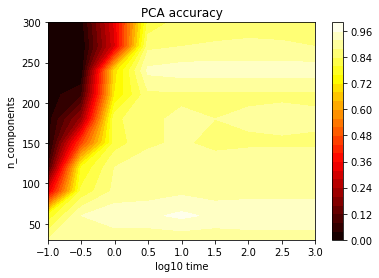

In [10]:
if Section_1 == 1:    

    Eigen.P['n_components'] = [];
    Eigen.P['Accuracy_vs_n_components'] =[];
    for i in range(len(ratio_list)):
        ratio = ratio_list[i];
        X_train, X_test, y_train, y_test = train_test_split(X, y);
        this_n = int(min(X_train.shape) * ratio);
        Eigen.P['n_components'].append(this_n);

        pca = PCA(n_components=this_n).fit(X_train);
        X_train_pca = pca.transform(X_train);
        classifier = SVC().fit(X_train_pca, y_train)

        mask = pca.components_;
        X_train_mean = pca.mean_;

        accu = [];
        for j in range(len(time_list)):        
            time = time_list[j];
            light_level = time * 1e6 / np.sum(np.abs(mask)); 
            ## 一次测量分正负，所以光强为原先一半， sum(mask_posi) 约等于 sum(mask_nega) 约等于 sum(abs(mask)) 的一半

            X_test_pca = Eigen_measure(mask, X_test, X_train_mean, light_level = light_level, Poisson = True);

            predictions = classifier.predict(X_test_pca);

            accu.append(np.mean(predictions == y_test));
            #print(accu)

        Eigen.P['Accuracy_vs_n_components'].append(accu);
        
    Eigen.P['Accuracy_vs_n_components'] = np.array(Eigen.P['Accuracy_vs_n_components']);
    contour(log_time_list, Eigen.P['n_components'], Eigen.P['Accuracy_vs_n_components'], xlabel = 'log10 time', ylabel = 'n_components',
           title = "PCA accuracy", user_levels = accuracy_levels);

Take the Binary of eigen mask:


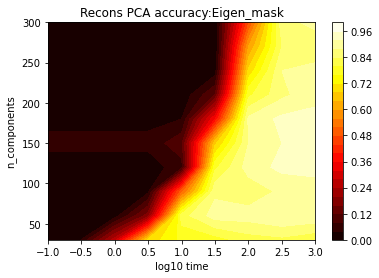

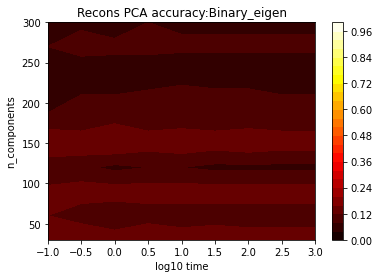

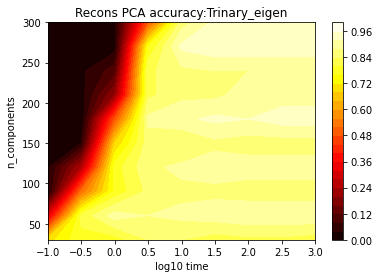

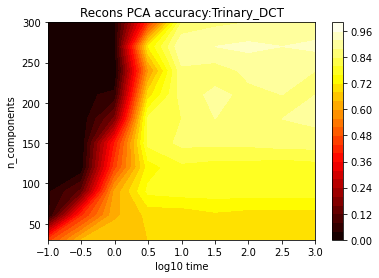

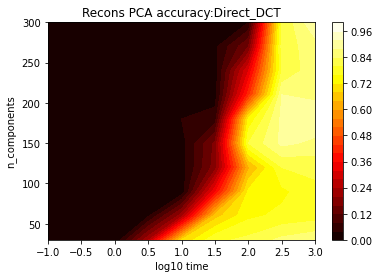

In [11]:
Binary_eigen = Research_object();
Binary_eigen.P['Accuracy_vs_n_components'] = [];
Binary_eigen.P['n_components'] = [];
Binary_eigen.P['name'] = "Binary_eigen";

Trinary_eigen = Research_object();
Trinary_eigen.P['Accuracy_vs_n_components'] = [];
Trinary_eigen.P['n_components'] = [];
Trinary_eigen.P['name'] = "Trinary_eigen";


Trinary_DCT = Research_object();
Trinary_DCT.P['Accuracy_vs_n_components'] = [];
Trinary_DCT.P['n_components'] = [];
Trinary_DCT.P['name'] = "Trinary_DCT";
get_mask = Masks();
dct_mtx = get_mask.DCT_Matrix(r*c);
Trinary_DCT.P['phi'] = 2*(dct_mtx > 0) - 1;

Direct_DCT = Research_object();
Direct_DCT.P['name'] = 'Direct_DCT';
Direct_DCT.P['Accuracy_vs_n_components'] = [];
Direct_DCT.P['n_components'] = [];
Direct_DCT.P['phi'] = (dct_mtx );

if Section_1 == 1:  
    obj_list = [Eigen, Binary_eigen, Trinary_eigen, Trinary_DCT, Direct_DCT];
    #obj_list = [Eigen];
    ratio_list = [(i+1)/10 for i in range (10)];
    
    for obj in obj_list:
        obj.P['Accuracy_vs_n_components'] = [];
        obj.P['n_components'] = [];      
    
        for i in range(len(ratio_list)):
            ratio = ratio_list[i];
            X_train, X_test, y_train, y_test = train_test_split(X, y);

            this_n = int(min(X_train.shape) * ratio);
            obj.P['n_components'].append(this_n);

            pca = PCA(n_components=this_n).fit(X_train);
            

            if obj == Eigen:
                mask = pca.components_;
            elif obj == Binary_eigen:
                mask = np.ceil(np.sign(pca.components_) / 2);
            elif obj == Trinary_eigen:
                mask = np.sign(pca.components_);
            elif obj in [Trinary_DCT, Direct_DCT]:
                mask = obj.P['phi'][:this_n,:];

            X_train_mean = pca.mean_;

            X_train_pca = (X_train - X_train_mean).dot(mask.T);
            #X_train_pca = pca.transform(X_train);
            classifier = SVC().fit(X_train_pca, y_train)

            accu = [];
            for j in range(len(time_list)):    
                time = time_list[j];
                light_level = time * 1e6 / np.sum(np.abs(mask)); 

                light_level = time * 1e6 / (mask.shape[0] * mask.shape[1]);
                
                if obj in [Eigen, Trinary_eigen, Trinary_DCT, Direct_DCT]:       
                    X_test_pca = Eigen_measure(mask, X_test, X_train_mean, light_level = light_level, Poisson = True);
                elif obj == Binary_eigen:
                    X_test_pca = (np.random.poisson(X_test.dot((mask).T) * light_level)/ light_level - X_train_mean.dot(mask.T)) ;
                
                

                predictions = classifier.predict(X_test_pca);

                accu.append(np.mean(predictions == y_test));

            obj.P['Accuracy_vs_n_components'].append(accu);

        obj.P['Accuracy_vs_n_components'] = np.array(obj.P['Accuracy_vs_n_components']);
        contour(log_time_list, obj.P['n_components'], (obj.P['Accuracy_vs_n_components']), 
                xlabel = 'log10 time', ylabel = 'n_components',
               title = "Recons PCA accuracy:" + obj.P['name'],  user_levels = accuracy_levels);

In [12]:
np.mean((pca.components_))

-5.921996283031078e-05

In [13]:
np.sum(np.sign(pca.components_)[1:,:])

-1516.0

In [14]:
np.sign(pca.components_).shape

(300, 4096)

In [15]:
np.sum((np.sign(pca.components_) / 2))

-2696.0

In [16]:
print(np.where(np.sign(pca.components_) + np.ceil(np.sign(pca.components_) / 2) == 1)); ## So if the answer is 0, that means all the 0 becomes -1
print(np.where(np.sign(pca.components_) + np.ceil(np.sign(pca.components_) / 2) == 0));## So if the answer is 0, that means all the 0 becomes -1
print(np.where(pca.components_ == 0)); ## so no 0 to worry about for pca method

elements = list((np.sign(pca.components_) + np.ceil(np.sign(pca.components_) / 2)).reshape(-1,));
print(set(elements));

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
{2.0, -1.0}


## Section 2
SNR analysis of measurement by PCA vs n_componengt and acquisition time.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y);
rand_index = np.random.randint(len(y_test));
X_select = X_test[rand_index:rand_index + 1, :];

Eigen.P['SNR_vs_n_components'] =[];
n_SNR_cycles = 50;

if Section_2 == 1:
    for i in range(len(Eigen.P['n_components'])):
        this_n = Eigen.P['n_components'][i];
        pca = PCA(n_components=this_n).fit(X_train);
        
        mask = pca.components_; #data写为列向量， mask写为行向量，统一标准
        mask_inv = mask.T;
        X_train_mean = pca.mean_;     
        mask_posi = np.array(mask);
        mask_posi[np.where(mask_posi < 0)] = 0;
        mask_nega = np.array(mask);
        mask_nega[np.where(mask_nega > 0)] = 0;
        
        this_snr_list = [];
        for j in range(len(time_list)):
            time = time_list[j];
            light_level = time * 1e6 / np.sum(np.abs(mask));
            
            
            recons_mat = np.zeros((r*c, n_SNR_cycles));
            for k in range(n_SNR_cycles):
                #measure_mat[k, :] = Eigen_measure(mask, X_select, X_train_mean, light_level = light_level, Poisson = True);
                #measure_mat[k, :] = np.random.poisson(X_select * light_level).dot(mask.T) / light_level;
                measure_posi = np.random.poisson(mask_posi.dot(X_select.T * light_level/2))##测两次，所以light_levek除以2
                measure_nega = np.random.poisson(-mask_nega.dot(X_select.T * light_level/2))
                measure = measure_posi - measure_nega;
                recons_mat[:,k] = (mask_inv.dot(measure)).reshape((-1,));
                
            this_snr = SNR_calc(recons_mat);
            this_snr_list.append(np.mean(this_snr));
        
        Eigen.P['SNR_vs_n_components'].append(this_snr_list);
    
    Eigen.P['SNR_vs_n_components'] = np.array(Eigen.P['SNR_vs_n_components']);
    contour(log_time_list, Eigen.P['n_components'], Eigen.P['SNR_vs_n_components'], xlabel = 'log10 time', ylabel = 'n_components',
           title = "PCA SNR");
            
        

In [18]:
if Section_2 == 1:
    contour(log_time_list, Eigen.P['n_components'], np.log10(Eigen.P['SNR_vs_n_components']), xlabel = 'log10 time', 
            ylabel = 'n_components',
           title = "log 10 PCA SNR");

## Section 3
SNR analysis of image reconstruction by Raster Scan, Basis Scan (DCT, rounded DCT)

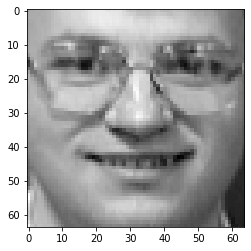

In [19]:

n_SNR_cycles = 50;

X_train, X_test, y_train, y_test = train_test_split(X, y);

rand_index = np.random.randint(len(y_test));
X_select = X_test[rand_index:rand_index + 1, :];

plt.figure(facecolor='w');
plt.imshow(X_select.reshape(r,c), cmap = 'gray');
plt.show();

In [20]:

if Section_3 == 1:
    RS = Research_object();
    BS_dct = Research_object();
    BS_round_dct = Research_object();

    get_mask = Masks();
    RS.add_item('phi', get_mask.Unity_matrix(r*c));
    RS.add_item('phi_inv', get_mask.Unity_matrix(r*c));

    dct_mtx = get_mask.DCT_Matrix(r*c);
    BS_dct.add_item("phi", dct_mtx);
    BS_dct.add_item("phi_inv", np.array(dct_mtx.T));
    
    mask = np.array(dct_mtx);
    mask_posi = np.array(mask);
    mask_posi[np.where(mask_posi < 0)] = 0;
    mask_nega = np.array(mask);
    mask_nega[np.where(mask_nega > 0)] = 0;
    BS_dct.add_item("phi_posi", mask_posi);
    BS_dct.add_item("phi_nega", mask_nega);
    

    dct_mtx_ceil = np.ceil(dct_mtx);
    BS_round_dct.add_item('phi',dct_mtx_ceil);
    BS_round_dct.add_item('phi_inv', np.linalg.pinv(dct_mtx_ceil));


In [21]:
if Section_3 == 1:    
    
    obj_list = [RS, BS_dct, BS_round_dct];
    #obj_list = [RS,  BS_round_dct];
    #obj_list = [RS]
    #for obj in [RS, BS_dct, BS_round_dct]:
    for obj in obj_list:
        obj.P['recons'] = [];
        obj.P['mean_SNR'] = [];
        obj.P['theory_SNR'] = [];
        
        mask = obj.P['phi'];
        mask_inv = obj.P['phi_inv'];        
        
        for i in range(len(time_list)):
            time = time_list[i];
            
            light_level = 1e6 * time / (r*c)**2; ## before mask constant
            light_level = 1e6 * time / np.sum(np.abs(mask)); ## after mask constant
            
            ## Theory
            noiseless_measure = mask.dot(X_select.T * light_level);
            covar_noiseless = (mask_inv.dot(np.diag(noiseless_measure.reshape((-1,))))).dot(mask_inv.T);
            obj.P['theory_SNR'].append(np.mean(X_select * light_level/np.diag(covar_noiseless)**0.5));
            
            ## simu
            recons = np.zeros((r*c, n_SNR_cycles));
            
            for j in range(n_SNR_cycles):
                #recons[:,j] = (Mask_recons(mask, mask_inv, X_select, light_level=light_level, Poisson = True)[0]);   
                ## 返回一个1 by N 的矩阵， 只需要第一行
                
                #measure = mask.dot(np.random.poisson(X_select.T * light_level));
                if obj == BS_dct: ##因为dct包含正负， 必须分别处理
                    mask_posi = obj.P['phi_posi'];
                    mask_nega = obj.P['phi_nega'];
                    
                    measure_posi = np.random.poisson(mask_posi.dot(X_select.T * light_level/2))##测两次，所以light_levek除以2
                    measure_nega = np.random.poisson(-mask_nega.dot(X_select.T * light_level/2))
                    
                    measure = measure_posi - measure_nega;
                    recons[:,j] = (mask_inv.dot(measure)).reshape((-1,));
                    
                else:                
                    measure = np.random.poisson(mask.dot(X_select.T * light_level))
                    recons[:,j] = (mask_inv.dot(measure)).reshape((-1,));  
            
            this_snr = SNR_calc(recons);
            '''
            covar = np.cov(recons);
            var_simu = np.diag(covar);
            mean_simu = np.mean(recons, axis = 1);
            this_snr = (mean_simu / (var_simu**0.5 + 1e-16));
            #print(np.mean(var_simu))
            '''
            
            obj.P['mean_SNR'].append(np.mean(this_snr));
            
            obj.P['recons'].append(np.mean(recons, axis = 1));
            
           
                
           
    RS.P['name'] = 'Raster';
    BS_dct.P['name'] = 'Basis_dct';
    BS_round_dct.P['name'] = 'Basis_round_dct';

    plt.figure(facecolor = 'w');
    for obj in obj_list:
        plt.plot(log_time_list, np.log10(obj.P['mean_SNR']), label = obj.P['name']);

    plt.legend();
    plt.xlabel('log10_time');
    plt.ylabel('log10_mean SNR');
    plt.title("image reconstruction SNR in log10 scale")
    plt.show();

## Section 4

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y);


if Section_4 == 1:
    RS = Research_object();
    BS_dct = Research_object();
    BS_round_dct = Research_object();
    BS_ternary_dct = Research_object();

    RS.P['name'] = 'Raster';
    BS_dct.P['name'] = 'Basis_dct';
    BS_round_dct.P['name'] = 'Basis_round_dct';
    BS_ternary_dct.P['name'] = 'Basis_ternary_dct';

    get_mask = Masks();
    RS.add_item('phi', get_mask.Unity_matrix(r*c));
    RS.add_item('phi_inv', get_mask.Unity_matrix(r*c));

    dct_mtx = get_mask.DCT_Matrix(r*c);
    BS_dct.add_item("phi", dct_mtx);
    BS_dct.add_item("phi_inv", np.array(dct_mtx.T));
    
    mask = np.array(dct_mtx);
    mask_posi = np.array(mask);
    mask_posi[np.where(mask_posi < 0)] = 0;
    mask_nega = np.array(mask);
    mask_nega[np.where(mask_nega > 0)] = 0;
    BS_dct.add_item("phi_posi", mask_posi);
    BS_dct.add_item("phi_nega", mask_nega);
    

    dct_mtx_ceil = np.ceil(dct_mtx);
    BS_round_dct.add_item('phi',dct_mtx_ceil);
    BS_round_dct.add_item('phi_inv', np.linalg.pinv(dct_mtx_ceil));

    dct_mtx_ternary = np.sign(dct_mtx);
    BS_ternary_dct.add_item('phi', dct_mtx_ternary);
    BS_ternary_dct.add_item('phi_inv', np.linalg.pinv(dct_mtx_ternary));

    mask = np.array(dct_mtx_ternary);
    mask_posi = np.array(mask);
    mask_posi[np.where(mask_posi < 0)] = 0;
    mask_nega = np.array(mask);
    mask_nega[np.where(mask_nega > 0)] = 0;
    BS_ternary_dct.add_item("phi_posi", mask_posi);
    BS_ternary_dct.add_item("phi_nega", mask_nega);

In [23]:
if Section_4 == 1:    
    
    obj_list = [RS, BS_dct, BS_round_dct, BS_ternary_dct];
    #obj_list = [RS,  BS_round_dct];
    #obj_list = [RS]
    #for obj in [RS, BS_dct, BS_round_dct]:
    
    ## measurement part
    for obj in obj_list:
        obj.P['recons'] = [];
        
        mask = obj.P['phi'];
        mask_inv = obj.P['phi_inv'];        
        
        for i in range(len(time_list)):
            time = time_list[i];
            
            light_level = 1e6 * time / (r*c)**2; ## before mask constant
            #light_level = 1e6 * time / np.sum(np.abs(mask)); ## after mask constant
            
            if obj in [BS_dct, BS_ternary_dct]: ##因为dct包含正负， 必须分别处理
                mask_posi = obj.P['phi_posi'];
                mask_nega = obj.P['phi_nega'];
                
                light_level2 = light_level / 2; ##测两次，所以light_levek除以2

                measure_posi = np.random.poisson(mask_posi.dot(X_test.T) * light_level2) / light_level2;
                measure_nega = np.random.poisson(-mask_nega.dot(X_test.T) * light_level2) / light_level2;

                measure = measure_posi - measure_nega;
                recons = (mask_inv.dot(measure)).T;                
                
            else:
                measure = np.random.poisson(mask.dot(X_test.T) * light_level)/light_level;
                recons = (mask_inv.dot(measure)).T;
                
            obj.P['recons'].append(recons);
            

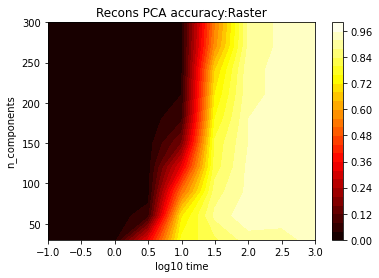

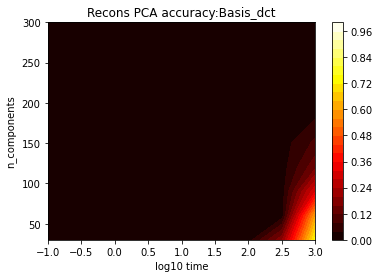

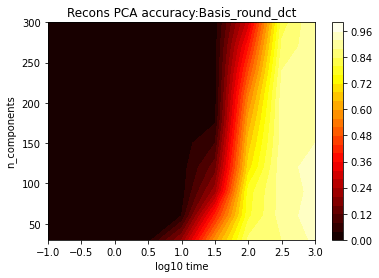

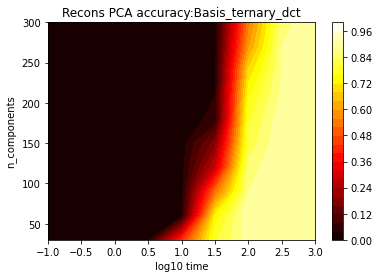

In [24]:
if Section_4 == 1:  
    obj_list = [RS, BS_dct, BS_round_dct, BS_ternary_dct];
    ratio_list = [(i+1)/10 for i in range (10)];
    
    for obj in obj_list:
        obj.P['Accuracy_vs_n_components'] = [];
        obj.P['n_components'] = [];      
    
        for i in range(len(ratio_list)):
            ratio = ratio_list[i];
            
            this_n = int(min(X_train.shape) * ratio);
            obj.P['n_components'].append(this_n);

            pca = PCA(n_components=this_n).fit(X_train);
            X_train_pca = pca.transform(X_train);
            classifier = SVC().fit(X_train_pca, y_train)

            #mask = pca.components_;
            #X_train_mean = pca.mean_;

            accu = [];
            for j in range(len(time_list)):        
                X_test_recon = obj.P['recons'][j]

                X_test_pca = pca.transform(X_test_recon);

                predictions = classifier.predict(X_test_pca);

                accu.append(np.mean(predictions == y_test));

            obj.P['Accuracy_vs_n_components'].append(accu);

        obj.P['Accuracy_vs_n_components'] = np.array(obj.P['Accuracy_vs_n_components']);
        contour(log_time_list, obj.P['n_components'], (obj.P['Accuracy_vs_n_components']), 
                xlabel = 'log10 time', ylabel = 'n_components',
               title = "Recons PCA accuracy:" + obj.P['name'],  user_levels = accuracy_levels);

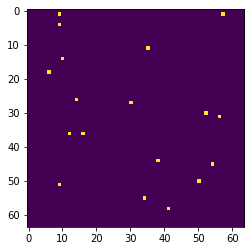

In [25]:
if Section_4 == 1:
    plt.imshow(RS.P['recons'][-9][0,:].reshape(64,64))

## Section 5 Anscombe Transform Software PCA


In [32]:
def Anscombe_transform(x):
    return 1000 * 2*(x - 3/8)*0.5;

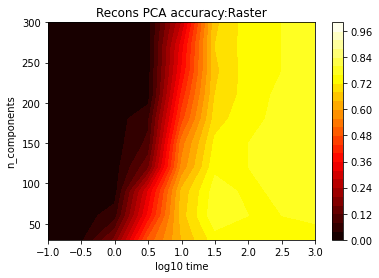

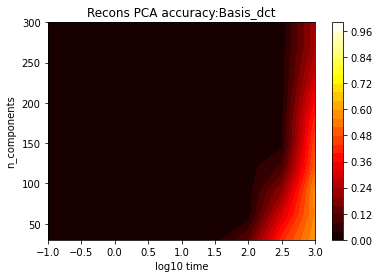

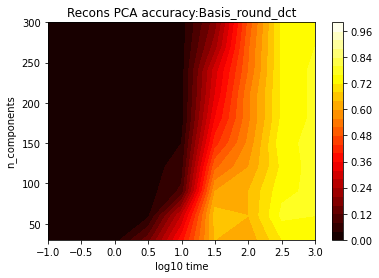

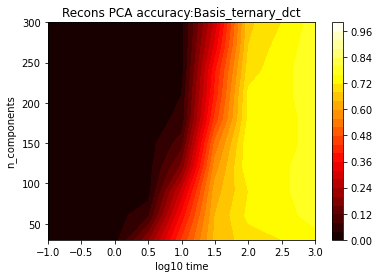

In [33]:
if Section_5 == 1:    
    
    obj_list = [RS, BS_dct, BS_round_dct, BS_ternary_dct];
    #obj_list = [RS,  BS_round_dct];
    #obj_list = [RS]
    #for obj in [RS, BS_dct, BS_round_dct]:
    
    ## measurement part
    for obj in obj_list:
        obj.P['recons'] = [];
        
        mask = obj.P['phi'];
        mask_inv = obj.P['phi_inv'];        
        
        for i in range(len(time_list)):
            time = time_list[i];
            
            light_level = 1e6 * time / (r*c)**2; ## before mask constant
            #light_level = 1e6 * time / np.sum(np.abs(mask)); ## after mask constant
            
            if obj in [BS_dct, BS_ternary_dct]: ##因为dct包含正负， 必须分别处理
                mask_posi = obj.P['phi_posi'];
                mask_nega = obj.P['phi_nega'];
                
                light_level2 = light_level / 2; ##测两次，所以light_levek除以2

                measure_posi = np.random.poisson(mask_posi.dot(X_test.T) * light_level2) / light_level2;
                measure_nega = np.random.poisson(-mask_nega.dot(X_test.T) * light_level2) / light_level2;

                measure = measure_posi - measure_nega;
                recons = (mask_inv.dot(measure)).T;                
                
            else:
                measure = np.random.poisson(mask.dot(X_test.T) * light_level)/light_level;
                recons = (mask_inv.dot(measure)).T;
                
            obj.P['recons'].append(recons);

if Section_4 == 1:  
    obj_list = [RS, BS_dct, BS_round_dct, BS_ternary_dct];
    ratio_list = [(i+1)/10 for i in range (10)];
    
    for obj in obj_list:
        obj.P['Accuracy_vs_n_components'] = [];
        obj.P['n_components'] = [];      
    
        for i in range(len(ratio_list)):
            ratio = ratio_list[i];
            
            this_n = int(min(X_train.shape) * ratio);
            obj.P['n_components'].append(this_n);

            pca = PCA(n_components=this_n).fit(X_train);
            X_train_pca = pca.transform(Anscombe_transform(X_train));
            classifier = SVC().fit(X_train_pca, y_train)

            #mask = pca.components_;
            #X_train_mean = pca.mean_;

            accu = [];
            for j in range(len(time_list)):        
                #X_test_recon = obj.P['recons'][j];

                X_test_recon = Anscombe_transform(obj.P['recons'][j]);

                X_test_pca = pca.transform(X_test_recon);

                predictions = classifier.predict(X_test_pca);

                accu.append(np.mean(predictions == y_test));

            obj.P['Accuracy_vs_n_components'].append(accu);

        obj.P['Accuracy_vs_n_components'] = np.array(obj.P['Accuracy_vs_n_components']);
        contour(log_time_list, obj.P['n_components'], (obj.P['Accuracy_vs_n_components']), 
                xlabel = 'log10 time', ylabel = 'n_components',
               title = "Recons PCA accuracy:" + obj.P['name'],  user_levels = accuracy_levels);            